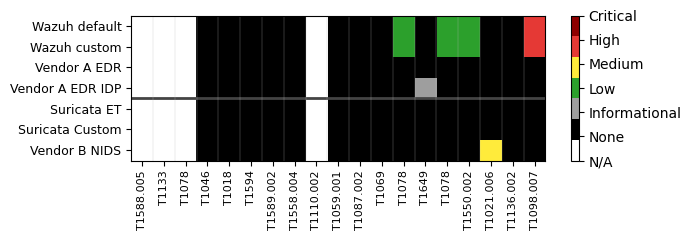

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def create_from_csv(name):
    csv_path = "csv/"+name+".csv"
    df = pd.read_csv(csv_path, sep=";")
 
    def extract_tid(s):
        if not isinstance(s, str):
            return s
        m = re.search(r"(T\d{4}(?:\.\d{3})?)", s)
        return m.group(1) if m else s
    
    df["TID"] = df["Technique"].apply(extract_tid)
    
    sev_map = {
        "informational": 2,
        "low": 3,
        "medium": 4,
        "high": 5,
        "critical": 6,
    }
    def parse_cell(x):
        if not isinstance(x, str):
            return 0
        s = x.strip().lower()
        if s.startswith("technique,"):
            sev = s.split(",", 1)[1].strip()
            return sev_map.get(sev, 0)
        if s.startswith("n/a"):
            return 0
        if s.startswith("none"):
            return 1
        return 0
    
    systems_all = list(df.columns[4:-1])
    for col in systems_all:
        df[col] = df[col].apply(parse_cell)
    
    def is_hids(name: str) -> bool:
        n = name.lower()
        return ("wazuh" in n) or ("edr" in n)
    
    def is_nids(name: str) -> bool:
        n = name.lower()
        return ("suricata" in n) or ("nids" in n) or ("snort" in n)
    
    hids = [c for c in systems_all if is_hids(c)]
    nids = [c for c in systems_all if is_nids(c)]
    others = [c for c in systems_all if c not in hids + nids]
    
    SORT_WITHIN_GROUPS = False
    if SORT_WITHIN_GROUPS:
        det_counts = (df[systems_all] > 1).sum(axis=0)
        sev_sums   = df[systems_all].sum(axis=0)
        hids = sorted(hids, key=lambda s: (det_counts[s], sev_sums[s]), reverse=True)
        nids = sorted(nids, key=lambda s: (det_counts[s], sev_sums[s]), reverse=True)
    
    systems_order = hids + nids + others
    
    tid_order = df["TID"].tolist()
    data_by_tid = df.set_index("TID")[systems_order]
    M = data_by_tid.T.values

    cmap = ListedColormap([
        "#FFFFFF",  # 0 = N/A
        "#000000",  # 1 = None
        "#9e9e9e",  # 2 = Informational
        "#2ca02c",  # 3 = Low (green)
        "#ffeb3b",  # 4 = Medium (yellow)
        "#e53935",  # 5 = High (red)
        "#8e0000",  # 6 = Critical (dark red)
    ])
    vmin, vmax = 0, 6
    
    plt.figure(figsize=(7, 2.5))
    im = plt.imshow(M, aspect="auto", interpolation="nearest",
                    cmap=cmap, vmin=vmin, vmax=vmax)
    
    plt.yticks(range(len(systems_order)), systems_order, fontsize=9)
    plt.xticks(range(len(tid_order)), tid_order, rotation=90, fontsize=8)
    
    if len(hids) > 0 and len(nids) > 0:
        y_sep = len(hids) - 0.5
        plt.axhline(y_sep, color="#444444", linewidth=2.0)

    for x in range(len(tid_order)):
        plt.axvline(x-0.5, color="#bbbbbb", linewidth=0.2)
    
    cbar = plt.colorbar(im, ticks=[0,1,2,3,4,5,6])
    cbar.ax.set_yticklabels(["N/A", "None", "Informational", "Low", "Medium", "High", "Critical"])
    
    plt.tight_layout()
    plt.savefig("images/"+name+".pdf", format="pdf", bbox_inches="tight")
    plt.show()

create_from_csv("eval_team6_run2")


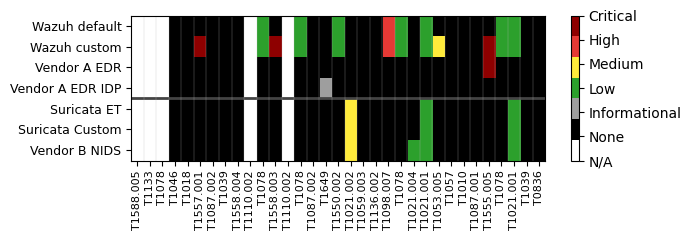

In [2]:
create_from_csv("eval_team2_run2")

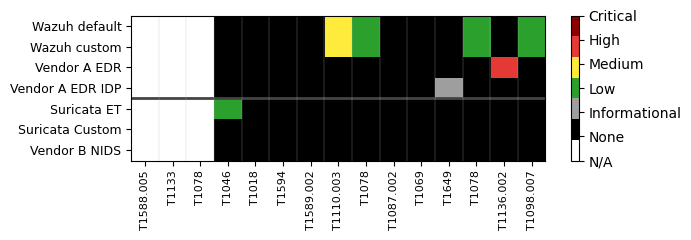

In [3]:
create_from_csv("eval_team9_run2")

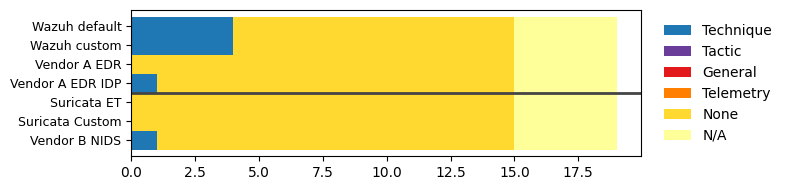

In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def create_eval_from_csv(name):
    csv_path = "csv/"+name+".csv"
    df = pd.read_csv(csv_path, sep=";")
    
    def parse_category(cell: str) -> str:
        if not isinstance(cell, str):
            return "N/A"
        s = cell.strip().lower()
        if s.startswith("technique,"):
            return "Technique"
        if s.startswith("none"):
            return "None"
        if s.startswith("n/a") or "n/a" in s:
            return "N/A"
        return "N/A"
    
    systems_all = list(df.columns[4:])
    
    category_colors = {
        "Tactic":     "#6a3d9a",  # purple
        "Technique":  "#1f78b4",  # blue
        "General":    "#e31a1c",  # red
        "Telemetry":  "#ff7f00",  # orange
        "None":       "#ffd92f",  # yellow (stronger)
        "N/A":        "#ffff99",  # light yellow
    }
    sort_order = ["Technique", "Tactic", "General", "Telemetry", "None", "N/A"]
    
    def is_hids(name: str) -> bool:
        n = name.lower()
        return ("wazuh" in n) or ("edr" in n)
    
    def is_nids(name: str) -> bool:
        n = name.lower()
        return ("suricata" in n) or ("nids" in n) or ("snort" in n)
    
    hids = [c for c in systems_all if is_hids(c)]
    nids = [c for c in systems_all if is_nids(c)]
    others = [c for c in systems_all if c not in hids + nids]
    systems_order = hids + nids + others
    
    def build_counts(series: pd.Series):
        counts = series.apply(parse_category).value_counts().to_dict()
        for k in sort_order:
            counts.setdefault(k, 0)
        return [(k, counts[k]) for k in sort_order if counts[k] > 0]
    
    counts_per_system = {sys: build_counts(df[sys]) for sys in systems_order}
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    max_right = 0
    for i, sys in enumerate(systems_order):
        segs = counts_per_system[sys]
        left = 0
        total = sum(n for _, n in segs)
        for cat, n in segs:
            if n <= 0: 
                continue
            ax.barh(i, width=n, left=left, color=category_colors[cat], edgecolor="none", height=1)
            left += n
        max_right = max(max_right, left)
    
    ax.set_yticks(range(len(systems_order)))
    ax.set_yticklabels(systems_order, fontsize=9)
    ax.invert_yaxis()  

    if len(hids) > 0 and len(nids) > 0:
        y_sep = len(hids) - 0.5
        ax.axhline(y_sep, color="#444444", linewidth=2.0)  # dark divider

    legend_handles = [Patch(facecolor=category_colors[k], label=k) for k in sort_order]
    ax.legend(
        handles=legend_handles,
        loc="center left",              # anchor legend's left-center
        bbox_to_anchor=(1.02, 0.5),     # shift it just outside the axes on the right
        ncol=1,                         # keep in one column (optional)
        frameon=False
    )
    plt.tight_layout()
    plt.savefig("images/mitre_"+name+".pdf", format="pdf", bbox_inches="tight")
    plt.show()


create_eval_from_csv("eval_team6_run2")

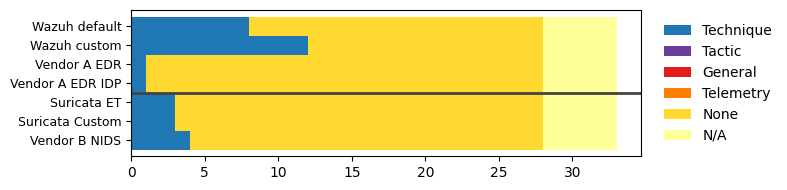

In [5]:
create_eval_from_csv("eval_team2_run2")

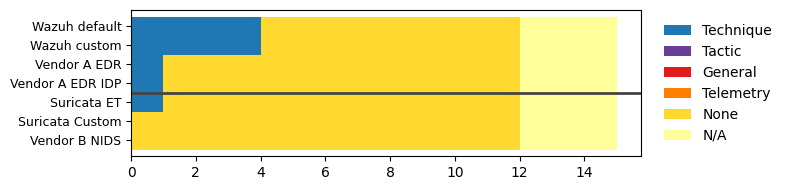

In [6]:
create_eval_from_csv("eval_team9_run2")